`Course Instructor`: **John Chiasson**

`Author (TA)`: **Ruthvik Vaila**

# Notes:
* In this notebook we shall load a large `NumPy` array directly into RAM to train a model.
* While the model is training keep an eye on the time taken and RAM usage of your machine.
* Tested on `Python 3.7.5` with `Tensorflow 1.15.0` and `Keras 2.2.4`. 
* Tested on `Python 2.7.17` with `Tensorflow 1.15.3` and `Keras 2.2.4`. 

# Imports

In [34]:
import sys, os
sys.version

'3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]'

In [35]:
from tensorflow.compat.v1 import InteractiveSession
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"]="0" #setting it to -1 hides the GPU.
#tf.compat.v1.enable_eager_execution()
from tensorflow.python.client import device_lib
import numpy as np
import IPython
import sys, pickle, os, gzip
#import h5py, time
import IPython.display as display
from keras.utils import to_categorical
import keras, warnings
import matplotlib.pyplot as plt
warnings.filterwarnings(action='once')
# GPU specific settings
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
session = InteractiveSession(config=config)
# this make sure that if using a gpu total gpu memory is not gobbled
# up by tensorflow and allows growth as required
##https://github.com/tensorflow/tensorflow/issues/24828

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [36]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16711829172239902913]

In [37]:
print('TF version:{}, Keras version:{}'.format(tf.__version__, keras.__version__))

TF version:1.15.0, Keras version:2.2.4


# Load the data
* There are `60000` images in the training set and each image needs to be of size `(28, 28, 1)` for `Keras`. The extra dimension in `(28, 28, 1)` indicates number of channels. In this case we have `1` channel because it's a gray scale image. In datasets like `CIFAR-10`, `CIFAR-100`, and `ImageNet` images have `3` channels `(RGB)`. 

In [47]:
filename = 'data/mnist.pkl.gz'
filehandle = gzip.open(filename, 'rb')
train_data, val_data, test_data = pickle.load(filehandle, encoding='latin1')
#train_data, val_data, test_data = pickle.load(filehandle)
filehandle.close()
train_x, train_y = train_data
print('train_x.shape:{} and train_y.shape:{}'.format(train_x.shape, train_y.shape))
val_x, val_y = val_data
print('val_x.shape:{} and val_y.shape:{}'.format(val_x.shape, val_y.shape))
print('images are 28*28 = 784 vectors')
#print(train_x[0]) # images are float32, normalized, and 784 vectors
print('')
# combine train and validation data as Keras will split it internally
train_x = np.concatenate([train_x, val_x], axis=0)
train_y = np.concatenate([train_y, val_y], axis=0)
print('train_x.shape:{}'.format(train_x.shape))
print('train_y.shape:{}'.format(train_y.shape))
print('')
print('train_x[0].shape:{}'.format(train_x.shape[0]))
print('train_x[1].shape:{}'.format(train_x.shape[1]))
print('')
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1)
print('train_x.shape:{}'.format(train_x.shape))
print('train_y.shape:{}'.format(train_y.shape))
print('train_x[59999].shape: {}'.format(train_x[59999].shape))
#print('train_x[0]: {}'.format(train_x[0]))
print('')
test_x, test_y = test_data
print('test_x.shape:{}'.format(test_x.shape))
test_x = test_x.reshape(test_x.shape[0], 28, 28, 1)
print('test_x.shape:{}'.format(test_x.shape))
print('test_y.shape:{}'.format(test_y.shape))
#train_x.shape[0]


train_x.shape:(50000, 784) and train_y.shape:(50000,)
val_x.shape:(10000, 784) and val_y.shape:(10000,)
images are 28*28 = 784 vectors

train_x.shape:(60000, 784)
train_y.shape:(60000,)

train_x[0].shape:60000
train_x[1].shape:784

train_x.shape:(60000, 28, 28, 1)
train_y.shape:(60000,)
train_x[59999].shape: (28, 28, 1)

test_x.shape:(10000, 784)
test_x.shape:(10000, 28, 28, 1)
test_y.shape:(10000,)


## One hot vectorize labels

In [48]:
train_y = to_categorical(train_y)
print('train_y.shape:{}'.format(train_y.shape))

test_y = to_categorical(test_y)
print('test_y.shape:{}'.format(test_y.shape))
train_y[0]

train_y.shape:(60000, 10)
test_y.shape:(10000, 10)


array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

## Visualize the dataset.
* The toggle command `ctrl + /` comments/uncomments multiple lines of code

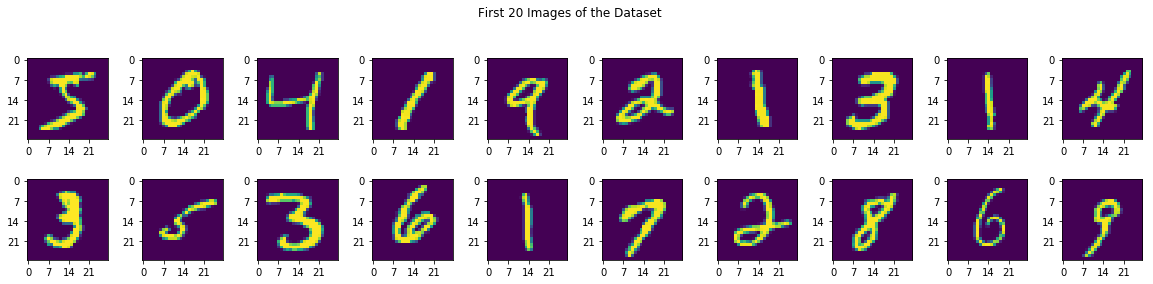

In [51]:
fig, axes = plt.subplots(2, 10, figsize=(20,4), subplot_kw={'xticks': range(0,28,7), 'yticks': range(0,28,7)})
fig.subplots_adjust(left=0.12, bottom=0.1, right=0.9, top=0.8, wspace=0.3, hspace=0.5)
#axes is a 2 by 10 array of the memory addresses of the subplots
#print(axes)
axes = axes.flatten()  #  axes is now a 1 by 20 array of the memory addresses of the subplots
#print(fig.shape)
#print(len(axes))
for i in range(len(axes)):
    axes[i].imshow(train_x[i,:,:,0])
plt.suptitle('First 20 Images of the Dataset')
plt.show()

#### Setup a small CNN model using `tf.keras.Sequential` 
* A simple convolutional neural network with the structure
* `32c32p64c64p->200->10`
* `Adam optimizer` and `Cross Entropy Loss` with a learning rate ($\alpha$) set to `0.005`.

In [53]:
eta = 0.0005
val_frac = 0.1 #Fraction of training data to be used for validation 
# FIRST CONVOLUTION LAYER
nC1_kernels = 32 ##number of kernels in the first convolutional layer
C1_kernel_shape = (5, 5) ## size of the kernel in the first convolutional layer (5,5)
C1_stride = (1,1) ## stride of the convolution 1 pixel right and 1 pixel down 
C1_activation = 'relu' ## activation function of the C1 neurons
P1_kernel_shape = (2, 2) ## Size of the pooling window (2,2) 
P1_stride = 2 ## stride of the pooling window

# SECOND CONVOLUTION LAYER
nC2_kernels = 64
C2_kernel_shape = (3, 3)
C2_stride = 1
C2_activation = 'relu'
P2_kernel_shape = (2, 2)
P2_stride = 2

# FULLY CONNECTED LAYER
n_dense = 200
dense_activation = 'relu'

# FINAL LAYER
last_activation = 'softmax'
cost_function = 'categorical_crossentropy'
n_out = 10
optimizer = 'adam' #'sgd'

In [58]:
# help(tf.keras.layers.Conv2D)
# Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), 
#        activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', 
#        kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, 
#        bias_constraint=None, **kwargs)

In [60]:
model = tf.keras.Sequential()

#FIRST CONVOLUTION LAYER
model.add(tf.keras.layers.Conv2D(nC1_kernels, C1_kernel_shape, C1_stride, activation=C1_activation,
                                input_shape=(28, 28, 1)))
# The 32 maps are 24x24   # 28-5+1 = 24
model.add(tf.keras.layers.MaxPooling2D(P1_kernel_shape, P1_stride))
# The 32 pooled maps are 12x12  
#SECOND CONVOLUTION LAYER
model.add(tf.keras.layers.Conv2D(nC2_kernels, C2_kernel_shape, C2_stride, activation=C2_activation))
# The 64 maps are 10x10   (12-3+1 = 10)
model.add(tf.keras.layers.MaxPooling2D(P2_kernel_shape, P2_stride))
# The 64 pooled maps are 5x5
model.add(tf.keras.layers.Flatten())
# This makes the 64 pooled 5x5 neuronal maps into a single 25*64 = 1600 neuron layer
#FULLY CONNECTED LAYERS
model.add(tf.keras.layers.Dense(n_dense, activation=dense_activation))
model.add(tf.keras.layers.Dense(n_out, activation=last_activation))

#COMPILE THE MODEL
if(optimizer=='adam'):
    optim = tf.keras.optimizers.Adam(lr=eta)
else:
    optim = tf.keras.optimizers.SGD(lr=eta)
    
model.compile(optimizer=optim, loss=cost_function, metrics=['accuracy'])
print(model.summary())

#CALLBACK TO KERAS TO SAVE BEST MODEL WEIGHTS
best_weights="cnn_weights_best.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights, monitor='val_acc', verbose=1, save_best_only=True,
                                                mode='max')


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               320200    
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

## Train the CNN

In [61]:
mini_batch_size = 32
history = model.fit(train_x,train_y, epochs=3, batch_size=mini_batch_size, callbacks=[checkpoint],
                   validation_split=val_frac)
# val_frac is fraction of the training data taken to be validation data

Train on 54000 samples, validate on 6000 samples
Epoch 1/3
53920/54000 [============================>.] - ETA: 0s - loss: 0.1603 - acc: 0.9516- ETA: 1
Epoch 00001: val_acc improved from -inf to 0.98367, saving model to cnn_weights_best.hdf5
54000/54000 [==============================] - 36s 666us/sample - loss: 0.1602 - acc: 0.9516 - val_loss: 0.0598 - val_acc: 0.9837
Epoch 2/3
53920/54000 [============================>.] - ETA: 0s - loss: 0.0509 - acc: 0.9838
Epoch 00002: val_acc improved from 0.98367 to 0.98550, saving model to cnn_weights_best.hdf5
54000/54000 [==============================] - 32s 597us/sample - loss: 0.0509 - acc: 0.9838 - val_loss: 0.0424 - val_acc: 0.9855
Epoch 3/3
53920/54000 [============================>.] - ETA: 0s - loss: 0.0352 - acc: 0.9890
Epoch 00003: val_acc improved from 0.98550 to 0.99017, saving model to cnn_weights_best.hdf5
54000/54000 [==============================] - 31s 567us/sample - loss: 0.0352 - acc: 0.9890 - val_loss: 0.0373 - val_acc: 0.

# Test the model at the end

In [62]:
model.evaluate(test_x, test_y, batch_size=len(test_x))

10000/10000 [==============================] - 1s 112us/sample - loss: 0.0296 - acc: 0.9899


[0.02964203804731369, 0.9899]

# Test at the best validation accuracy

In [63]:
model.load_weights(best_weights)
model.compile(optimizer=optim, loss=cost_function, metrics=['accuracy'])
model.evaluate(test_x, test_y, batch_size=len(test_x))

10000/10000 [==============================] - 1s 116us/sample - loss: 0.0296 - acc: 0.9899


[0.02964203804731369, 0.9899]

# Restart the notebook to free up the `GPU` and `RAM`.

In [ ]:
IPython.Application.instance().kernel.do_shutdown(True) #automatically restarts kernel